In [1]:
import networkx as nx
import numpy as np
import scipy as sp
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from community import community_louvain
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from utils import load_network
from tqdm import tqdm
import concurrent.futures 

G = load_network()

In [2]:
import pickle

filename = 'louvain-runs.bin'
n_runs = 100

try:
    community_results = pickle.load(open(filename, 'rb'))
except:
    community_results = dict()
    # change max_workers to the number of processors on your machine
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:

        def thread_fn(i):
            community_results[i] = community_louvain.best_partition(G)
            print(f'run {i} done!') 

        executor.map(thread_fn, range(n_runs))
    pickle.dump(community_results, open(filename, 'wb'))

In [3]:
protein1 = ['PDA1', 'PDB1', 'LAT1', 'LPD1'] # pdh complex
protein2 = ['PKP1', 'PKP2', 'PTC5'] # pdh regulators

def check_same_communities(community_results, protein_list):
    bad_indices = set()
    for idx, communities in community_results.items():
        # print(communities)
        protein_comms = list(communities[p] for p in protein_list)
        identical_community = protein_comms.count(protein_comms[0]) == len(protein_comms)
        if not identical_community: 
            print(f"proteins in {protein_list} do not all belong to the same community, skipping this run!")
            bad_indices.add(idx)
    if len(bad_indices) == 0:
        print(f"all proteins {protein_list} belong to a single community, over all runs of Louvain!")
    
    each_community = list()
    intersection_sizes = list()
    for idx, communities in community_results.items():
        if idx in bad_indices:
            print(f'skipping {community_index}')
        else:
            # find thie community that the protein belongs to
            community_index = communities[protein_list[0]]
            protein_community = set(p for p in communities if communities[p] == community_index)
            # print(f'run {idx}, community size {len(protein_community)}')
            each_community.append(protein_community)
            intersection_sizes.append(len(set.intersection(*each_community)))
    print('intersection community size', len(set.intersection(*each_community)))

    # ignore the first 10 intersects as they have very large sizes
    plt.plot(range(5,len(intersection_sizes)), intersection_sizes[5:], 'o')
    
    return set.intersection(*each_community)

all proteins ['PDA1', 'PDB1', 'LAT1', 'LPD1'] belong to a single community, over all runs of Louvain!
intersection community size 62


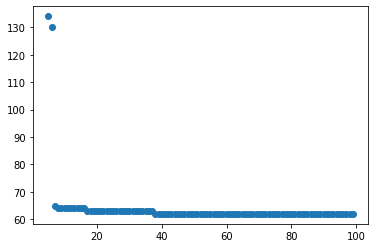

In [5]:
common_nodes = check_same_communities(community_results, protein1)
G_comm = G.subgraph(common_nodes)

In [6]:
# Week 9: Find new proteins of interest within common nodes
proteins_wk9 = ["LIP5", "LIP1", "NFU1", "LAT1"]
for p in proteins_wk9:
    if p not in common_nodes:
        print("Protein {} not in common nodes.".format(p))
    else:
        print("Protein {} found.".format(p))
# Conclusion: Only LAT1 found in the common nodes.

lat1_edges = [x[1] for x in G.edges("LAT1")]

# See if the other three proteins are connected to LAT1
for p in proteins_wk9:
    if p not in lat1_edges:
        print("Protein {} not connected to LAT1".format(p))
    else:
        print("Protein {} connected to LAT1".format(p))
# Conclusion: Only LIP5 connected to LAT1

Protein LIP5 not in common nodes.
Protein LIP1 not in common nodes.
Protein NFU1 not in common nodes.
Protein LAT1 found.
Protein LIP5 connected to LAT1
Protein LIP1 not connected to LAT1
Protein NFU1 not connected to LAT1
Protein LAT1 not connected to LAT1
